In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from modelbase2 import mc
from modelbase2.ode import Model


In [28]:
def constant(x: float) -> float:
    return x


def mass_action(x: float, k: float) -> float:
    return x * k


def get_model() -> Model:
    return (
        Model()
        .add_compounds(["x", "y"])
        .add_parameters(
            {
                "k0": 1,
                "k1": 1,
                "k2": 1,
            }
        )
        .add_reaction_from_args("v0", constant, {"x": 1}, ["k0"])
        .add_reaction_from_args("v1", mass_action, {"x": -1, "y": 1}, ["x", "k1"])
        .add_reaction_from_args("v2", mass_action, {"y": -1}, ["y", "k2"])
    )


y0 = {"x": 0, "y": 0}
time_points = np.linspace(0, 10, 51)
psample = mc.sample(
    {
        "k0": mc.LogNormal(mean=0.5, sigma=0.1),
        "k1": mc.Uniform(1, 2),
        "k2": mc.Skewnorm(loc=1, scale=0.1, a=0.5),
    },
    n=6,
)

100%|██████████| 6/6 [00:00<00:00, 27.21it/s]


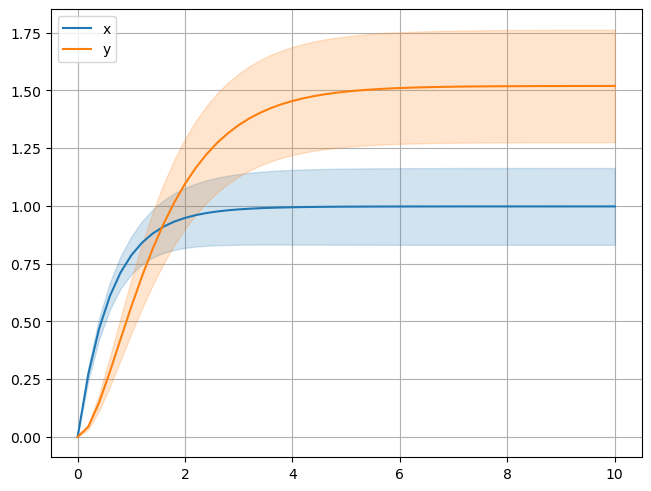

In [29]:
mctc = mc.time_course(
    get_model(),
    y0,
    time_points=time_points,
    mc_parameters=psample,
)
ax = mctc.plot_line_mean_std("concs", "x")
ax = mctc.plot_line_mean_std("concs", "y", ax=ax)
ax.legend()
plt.show()

100%|██████████| 6/6 [00:00<00:00, 26.00it/s]


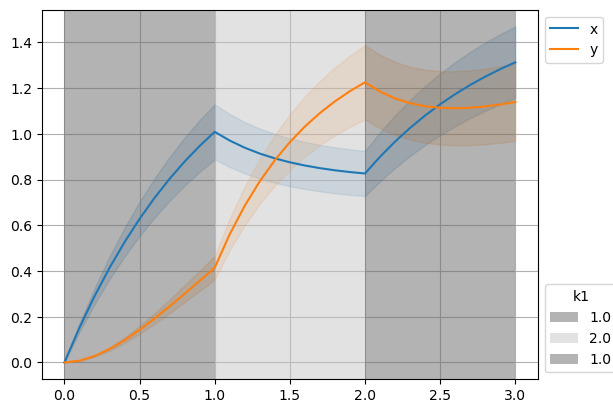

In [30]:
protocol = pd.DataFrame(
    {
        "k1": {
            pd.Timedelta(seconds=1): 1.0,
            pd.Timedelta(seconds=2): 2.0,
            pd.Timedelta(seconds=3): 1.0,
        }
    }
)

mctp = mc.time_course_over_protocol(
    model=get_model(),
    y0=y0,
    protocol=protocol,
    mc_parameters=psample.drop(columns=["k1"]),
)

fig, ax = plt.subplots()
mctp.plot_line_mean_std("concs", "x", ax=ax)
mctp.plot_line_mean_std("concs", "y", ax=ax)
mctp.shade_protocol("k1", ax=ax, vmin=0, vmax=3)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.0, 1.0),
)
plt.show()

100%|██████████| 6/6 [00:00<00:00, 33.49it/s]


<Axes: >

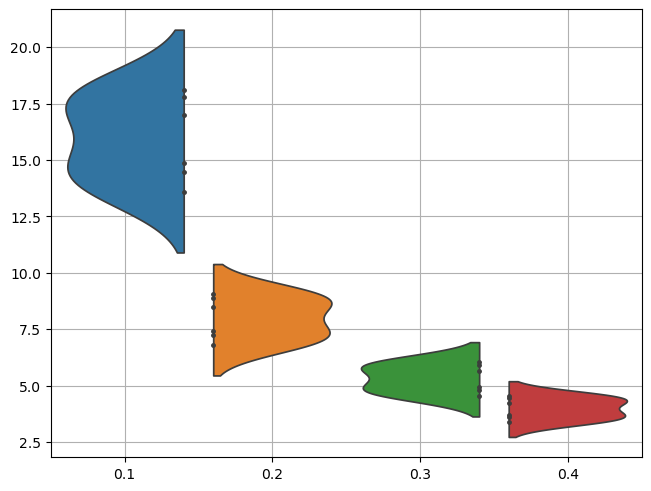

In [31]:
mcss = mc.steady_state_scan(
    get_model(),
    y0=y0,
    parameter="k1",
    parameter_values=np.array([0.1, 0.2, 0.3, 0.4]),
    mc_parameters=psample.drop(columns=["k1"]),
)

mcss.plot_violin("concs", "x")